In [8]:
import os
import sys
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from skimage.transform import resize
from mpl_toolkits.mplot3d import Axes3D

sys.path.append(os.path.dirname(os.path.abspath('')))
import utils.prepare_data as pd
import utils.visualize as visual
import utils.convert_xyz_uvd as xyzuvd
import utils.camera_info as cam

In [3]:
dataset_dir = '/media/aaron/SHAREDDATA/First_Person_Action_Benchmark'
save_dir = '/media/aaron/SHAREDDATA/data'
train_pairs, test_pairs = pd.get_fpha_data_list('color', dataset_dir)



(1080, 1920, 3)
/media/aaron/SHAREDDATA/First_Person_Action_Benchmark/Video_files/Subject_1/squeeze_paper/2/color/color_0065.jpeg


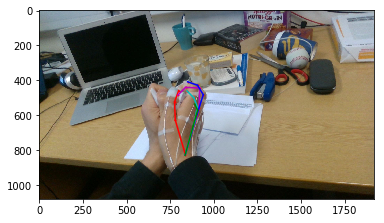

In [121]:
file_name = [i for i,j in train_pairs]
xyz_gt = [j for i,j in train_pairs]
idx = 5000
frame = file_name[idx]
xyz_gt = np.reshape(xyz_gt, (-1, 21, 3))
xyz_gt = xyz_gt[idx]
uvd_gt = xyzuvd.xyz2uvd_color(xyz_gt)
color = Image.open(frame)
color = np.asarray(color, dtype='uint32')
print(color.shape)
print(frame)
visual.show_img_and_skel_color(file_name[idx], uvd_gt)


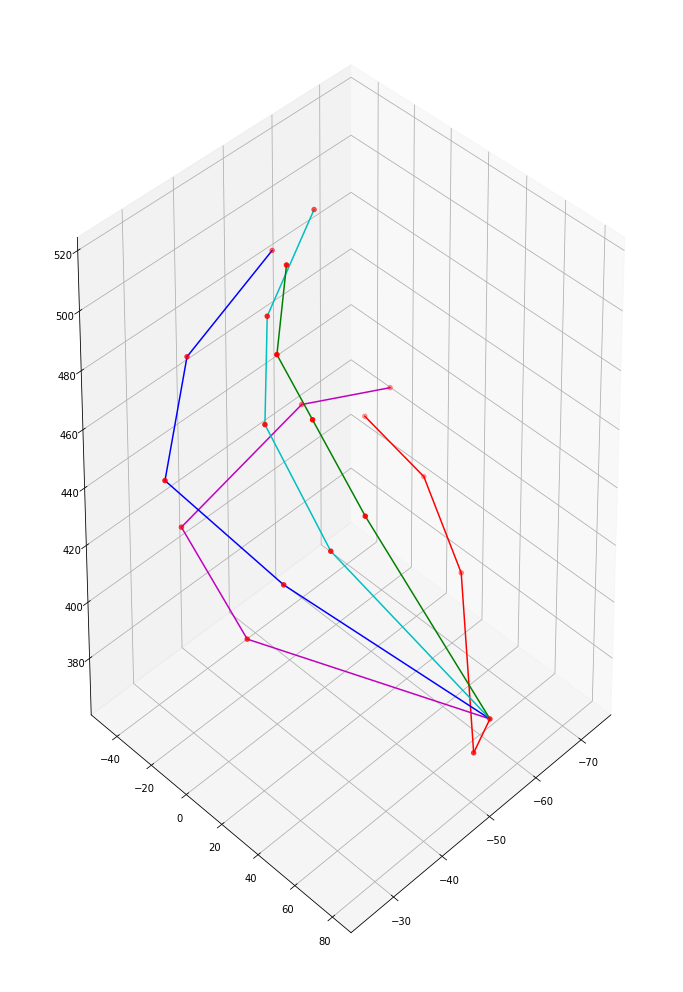

In [122]:
REORDER = [0, 1, 6, 7, 8, 2, 9, 10, 11, 3, 12, 13, 14, 4, 15, 16, 17, 5, 18, 19, 20]

fig = plt.figure(figsize=(12, 18))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.view_init(elev=30, azim=45)

visual.visualize_joints_3d(ax, xyz_gt[REORDER], joint_idxs=False)
plt.show()

In [123]:
def left_handed_rot_mat(dim, angle):
    c, s = np.cos(angle), np.sin(angle)
    if dim == 'x':
        rot_mat = [[1., 0, 0],
                   [0, c, s],
                   [0, -s, c]]
    elif dim == 'y':
        rot_mat = [[c, 0, -s],
                  [0, 1, 0],
                  [s, 0, c]]
    elif dim == 'z':
        rot_mat = [[c, s, 0],
                   [-s, c, 0],
                   [0, 0, 1]]
    else:
        raise ValueError('dim needs to be x, y or z')
    
    return rot_mat

def rad(angle):
    return np.radians(angle)

def deg(angle):
    return np.degrees(angle)

xyz_gt = np.expand_dims(xyz_gt, axis=0)
print(xyz_gt.shape)

(1, 21, 3)


In [124]:
coords_xyz = xyz_gt

ROOT_NODE_ID = 0
ALIGN_NODE_ID = 3 #beg middle
ROT_NODE_ID = 5 #beg pinky

# 1. Translate the whole set s.t. the root kp is located in the origin
trans = coords_xyz[:, ROOT_NODE_ID, :]
coords_xyz_t = coords_xyz - trans

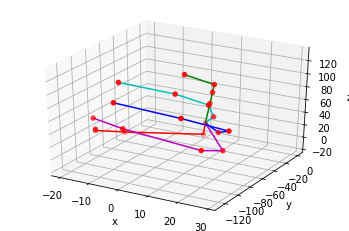

In [125]:
REORDER = [0, 1, 6, 7, 8, 2, 9, 10, 11, 3, 12, 13, 14, 4, 15, 16, 17, 5, 18, 19, 20]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')

plotthis = np.squeeze(coords_xyz_t)
visual.visualize_joints_3d(ax, plotthis[REORDER], joint_idxs=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [126]:
# 2. Rotate and scale keypoints such that the root bone is of unit length and aligned with the y axis
p = coords_xyz_t[:, ALIGN_NODE_ID, :]  # thats the point we want to put on (0/1/0)

# Rotate point into the yz-plane
alpha = np.arctan2(p[:, 0], p[:, 1])

rot_mat = left_handed_rot_mat('z', alpha)

coords_xyz_t_r1 = np.matmul(coords_xyz_t, rot_mat)
total_rot_mat = rot_mat

[[7.10542736e-15 6.67938635e+01 3.83089000e+01]]


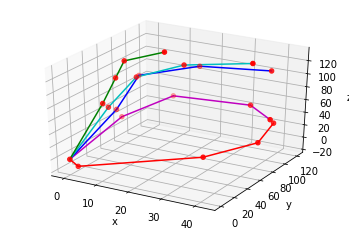

In [127]:
REORDER = [0, 1, 6, 7, 8, 2, 9, 10, 11, 3, 12, 13, 14, 4, 15, 16, 17, 5, 18, 19, 20]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
p = coords_xyz_t_r1[:, ALIGN_NODE_ID, :]
print(p)

plotthis = np.squeeze(coords_xyz_t_r1)
visual.visualize_joints_3d(ax, plotthis[REORDER], joint_idxs=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [128]:
# Rotate point within the yz-plane onto the xy-plane
p = coords_xyz_t_r1[:, ALIGN_NODE_ID, :]
beta = -np.arctan2(p[:, 2], p[:, 1])
rot_mat = left_handed_rot_mat('x', beta + 3.141592653589793)
coords_xyz_t_r2 = np.matmul(coords_xyz_t_r1, rot_mat)
total_rot_mat = np.matmul(total_rot_mat, rot_mat)

[[ 7.10542736e-15 -7.69999482e+01  7.10542736e-15]]


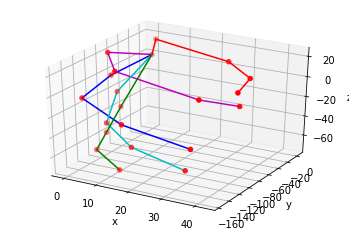

In [129]:
REORDER = [0, 1, 6, 7, 8, 2, 9, 10, 11, 3, 12, 13, 14, 4, 15, 16, 17, 5, 18, 19, 20]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
p = coords_xyz_t_r2[:, ALIGN_NODE_ID, :]
print(p)

plotthis = np.squeeze(coords_xyz_t_r2)
visual.visualize_joints_3d(ax, plotthis[REORDER], joint_idxs=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [130]:
# 3. Rotate keypoints such that rotation along the y-axis is defined
p = coords_xyz_t_r2[:, ROT_NODE_ID, :]
gamma = np.arctan2(p[:, 2], p[:, 0])
rot_mat = left_handed_rot_mat('y', gamma)
coords_xyz_normed = np.matmul(coords_xyz_t_r2, rot_mat)
total_rot_mat = np.matmul(total_rot_mat, rot_mat)

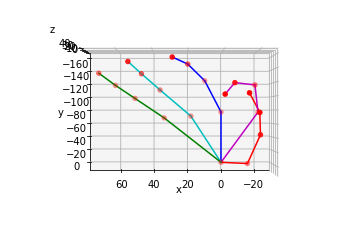

In [131]:
REORDER = [0, 1, 6, 7, 8, 2, 9, 10, 11, 3, 12, 13, 14, 4, 15, 16, 17, 5, 18, 19, 20]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.view_init(elev=90, azim=90)

plotthis = np.squeeze(coords_xyz_normed)
visual.visualize_joints_3d(ax, plotthis[REORDER], joint_idxs=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()